### Importing the Libraries

In [3]:
import pandas as pd
import numpy as np
import os
import wikipedia
import requests
from threading import Lock
import re
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import plotly
import plotly.plotly as py 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

plotly.tools.set_credentials_file(username='TheInfamousWayne', api_key='5o9cWieXjnukrtxb6sL3')
init_notebook_mode(connected=True)

C:\Users\Bhavya\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Bhavya\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Utility Classes, Functions & Variables

In [2]:
# %load links/utils.py
QUERY_DICT = {'Organization Founded By^-1':["""SELECT ?item ?itemLabel WHERE {
                                          ?item wdt:P112 wd:%s.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                           ],
              'Organization Founded By':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P112 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                        ],
              'Organization Headquarters':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P159 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                          ],
              'Organization Subsidiary Of^-1':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P355 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                              ],
              'Organization Subsidiary Of':["""SELECT ?item ?itemLabel WHERE {
                                          ?item wdt:P355 wd:%s.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                           ],
              'Organization top employees':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P169 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }""", # CEO
                                            """SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P488 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }""" # Chairperson
                                            ],
              'Person Employee or Member of^-1':["""SELECT ?item ?itemLabel WHERE {
                                          ?item wdt:P108 wd:%s.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }""",
                                            """SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P527 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }""" 
                                                ],
              'Person Employee or Member of':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P108 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""",
                                              """SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P463 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""## member of ---> Band Members
                                            ],
              'Person Place of Birth':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P19 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                      ],
              'Person Current and Past Location of Residence':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P551 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                                              ],
              'Person Parents':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P22 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""", #Father
                                """SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P25 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""", #Mother
                                """SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P1038 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""" #Relative (Adopted Parents?)
                                # Shall we include stepparents??
                               ],
              'Person Parents^-1':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P40 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                  ],
              'Person Siblings':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P3373 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                ],
              'Person Spouse':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P26 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                              ],
              'Citizen of':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P27 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                           ],
              'Educated at':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P69 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                            ]
             }




from SPARQLWrapper import SPARQLWrapper, JSON   
from rosette.api import API, DocumentParameters, RosetteException
import pandas as pd
import wikipedia
import requests
import numpy as np
import pickle
import random
from threading import Lock
import os, sys
import threading
from threading import Thread
import time
import queue

class Utils:
    
    def __init__(self):
        self.id_dict = {}
        self.lock = Lock()
        self.load_dict()
        
    
    def __del__(self):
        self.save_dict()

    def get_id(self, message, dict_to_use=None):
#         if dict_to_use:
#             dict_to_use = dict_to_use
#         else:
#             global id_dict
#             dict_to_use = id_dict
    
        if message in self.id_dict:
            return self.id_dict[message]
        else:
            API_ENDPOINT = "https://www.wikidata.org/w/api.php"
            query = message
            params = {
                'action': 'wbsearchentities',
                'format': 'json',
                'language': 'en',
                'search': query
            }
            r = requests.get(API_ENDPOINT, params = params)
            try:
                with self.lock:
                    self.id_dict[message] = r.json()['search'][0]['id']
                return self.id_dict[message]
            except Exception:
                return -1 #The id doesn't exist


    def id_to_name(self, eid):
#         if dict_to_use:
#             dict_to_use = dict_to_use
#         else:
#             global id_dict
#             dict_to_use = id_dict

        if eid in self.id_dict.values():
            return [key for key, value in self.id_dict.items() if value == eid][0]
        else:
            API_ENDPOINT = "https://www.wikidata.org/w/api.php"
            query = eid
            params = {
                'action': 'wbsearchentities',
                'format': 'json',
                'language': 'en',
                'search': query
            }
            r = requests.get(API_ENDPOINT, params = params)
            try:
                with self.lock:
                    self.id_dict[ r.json()['search'][0]['label'] ] = r.json()['search'][0]['id']
                return r.json()['search'][0]['label']
            except Exception:
                return -1 #The id doesn't exist


    def get_results(self, query, value, endpoint_url="https://query.wikidata.org/sparql"):
        sparql = SPARQLWrapper(endpoint_url)
        sparql.setQuery(query%value)
        sparql.setReturnFormat(JSON)
        return sparql.query().convert()


    def ground_truth(self, relation, subject, debug=False):
        global QUERY_DICT
        results = []
        gt = []
        try:
            results = [self.get_results(query, self.get_id(subject)) for query in QUERY_DICT[relation]]
            for result in results:
                for r in result["results"]["bindings"]:
                    gt.append(r['itemLabel']['value'])
        except:
            if debug:
                print (relation, subject)
        return gt

    def add_ground_truth(self, df, debug=False):
        if df.empty:
            return df
        if debug:
            print (df)
        df = df.reset_index()
        df['Pseudo Ground Truth'] = df.apply(lambda row: self.ground_truth(row['Relationship'], row['Subject']), axis=1)
        df['Count_PGT'] = df['Pseudo Ground Truth'].apply(lambda x: len(x))
        df = df.set_index(['Subject','Relationship'])
        return df

    def add_recall_score(self, df):
        df['Recall Prediction'] = np.random.randint(0, 100, df.shape[0])/100
        return df


    def load_dict(self):
        try:
            with open('data/dumps/id_dict.pkl', 'rb') as fp:
                self.id_dict = pickle.load(fp)
        except:
            print ("Creating a new Dictionary")
            self.id_dict = {}


    def save_dict(self):
        with self.lock:
            old_dict = self.get_dict()
            self.id_dict = {**self.id_dict, **old_dict}
            with open('data/dumps/id_dict.pkl', 'wb') as fp:
                pickle.dump(self.id_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
                print("Saved")


    def get_dict(self):
        di = {}
        with open('data/dumps/id_dict.pkl', 'rb') as fp:
            di = pickle.load(fp)
        return di


    def Analyse(self, message, alt_url='https://api.rosette.com/rest/v1/'):
        """ Run the example """
        # Create an API instance
        api = API(user_key="969b3593686184bb42803d8da453f119", service_url=alt_url)

        # Set selected API options.
        # For more information on the functionality of these
        # and other available options, see Rosette Features & Functions
        # https://developer.rosette.com/features-and-functions#morphological-analysis-introduction

        # api.set_option('modelType','perceptron') #Valid for Chinese and Japanese only

        # Opening the ID Dictionary
#         load_dict()
        ### Will Close after Analysis of the document is completed

        params = DocumentParameters()
        relationships_text_data = wikipedia.page(message).content[:20000]
        params["content"] = relationships_text_data
        rel = []
        message_id = self.get_id(message)
        message_split = message.split(" ")
        try:
            RESULT = api.relationships(params)
            #print(RESULT)
            for r in RESULT['relationships']:
                arg2_split = r['arg2'].split(" ")
                confidence = '?'
                if "confidence" in r:
                    confidence = str(round(r["confidence"],2))
                if any(s in arg2_split for s in message_split):
                    if self.get_id(r['arg2']) == message_id:
                        rel.append({'Relationship':r['predicate']+'^-1', 'Subject':r['arg2'], 'Object':r['arg1'], 'Confidence': confidence})
                rel.append({'Relationship':r['predicate'],'Subject':r['arg1'],'Object':r['arg2'], 'Confidence': confidence})

            ## Closing the ID Dict
            self.save_dict()
            ##
            return rel, message_id
        except RosetteException as exception:
            print(exception)


class HeatMaps(Thread):
    def __init__(self, lock, relation='Educated at', eid=None, name=None, rel_dict={}):
        Thread.__init__(self)
        self.q1 = queue.Queue()
        self.q2 = queue.Queue()
        self.u = Utils()
        self.lock = lock
        self.rel_dict = rel_dict
        self.eid = eid
        self.message = name
        self.error = None
        self.relation = relation
        self.inverse = True if "^-1" in relation else False
        if name:
            self.eid = self.u.get_id(name)
        else:
            self.message = str(self.u.id_to_name(eid))
        self.start()
        
        
    def run(self):
        if self.eid not in self.rel_dict:
            a = Thread(target = self.Analyse, args = ())
            b = Thread(target = self.ground_truth, args = ())
            a.start()
            b.start()
            a.join()
            b.join()
        self.matrix_block()


    def Analyse(self):
        """ Run the example """
        # Create an API instance
        api = API(user_key="969b3593686184bb42803d8da453f119", service_url='https://api.rosette.com/rest/v1/')
#         u = Utils()
        params = DocumentParameters()
        relationships_text_data = []
        
        while True:
            try:
                relationships_text_data = wikipedia.page(self.message).content[:20000]
                break
            except wikipedia.DisambiguationError as e:
                print(self.eid, self.message)
                nameclash = True
                for n in e.options:
                    if self.u.get_id(n) == self.eid:
                        if n == self.message:
                            pass
                        else:
                            self.message = n
                            nameclash = False
                            break
                if nameclash:
                    self.message = " "
            except wikipedia.exceptions.PageError as e:
                self.error = self.u.id_to_name(self.eid) + " " + str(e)
                print (self.error)
                break
            
        
        try:
            params["content"] = relationships_text_data
            rel = []
            message_id = self.u.get_id(self.message)
            message_split = self.message.split(" ")
            pred_list = []
            RESULT = []
            with self.lock:
                RESULT = api.relationships(params)
            
            args = ['arg1','arg2']
            arg_to_split = 'arg2' if self.inverse else 'arg1'
            args.remove(arg_to_split)
            other_arg = args[0]
            rel_to_compare = self.relation.split("^-1")[0]
                
            for r in RESULT['relationships']:
                if r['predicate'] == rel_to_compare:
                    arg_split = r[arg_to_split].split(" ") # Subject Split 
                    if any(s in arg_split for s in message_split): # Searching for alias names
                        if self.u.get_id(r[arg_to_split]) == message_id:
                            pred_list.append(r[other_arg])
                            
            self.q1.put(set(pred_list))
        except RosetteException as exception:
            print(exception)
            self.error = exception
            self.q1.put(set(pred_list))
        except Exception as e:
            print(e, self.message)
            self.error = e
            self.q1.put(set(pred_list))


    def ground_truth(self):
#         u = Utils()
        
        pgt = set(self.u.ground_truth(self.relation, self.message))
        self.q2.put(pgt)
    
    
    def matrix_block(self):
        if self.eid in self.rel_dict:
            self.pgt = self.rel_dict[self.eid]['PGT']
            self.extracted = self.rel_dict[self.eid]['Extracted']
            self.contained = self.rel_dict[self.eid]['Contained']
        else:
            q1 = self.q1.get() # Extracted from API
            q2 = self.q2.get() # PGT
            #print(self.message, q1)
            #print(self.message, q2)
            self.pgt = len(q2)
            self.extracted = len(q1)
            q1 = [self.u.get_id(i) for i in q1]
            q2 = [self.u.get_id(i) for i in q2]
            #print(self.message, q1)
            #print(self.message, q2)
            count = 0
            for i in q1:
                if i in q2:
                    count += 1
            self.contained = count

    def get_values(self):
        if self.error:
            raise Exception(self.error)
        return [self.eid, self.message, self.extracted, self.contained, self.pgt]
    
    
    
    
class Distribution(Thread):
    def __init__(self, eid=None, name=None, lock=None, rel_dict={}):
        Thread.__init__(self)
        self.doc_len = None
        self.u = Utils()
        self.eid = eid
        self.message = name
        self.error = None
        if name:
            self.eid = self.u.get_id(name)
        else:
            self.message = self.u.id_to_name(eid)
        if eid in rel_dict:
            self.doc_len = rel_dict[eid]['Doc_Length']
            return
        self.start()
    
    def run(self):
        while True:
            try:
                document = wikipedia.page(self.message).content
                self.doc_len = len(document)
                break
            except wikipedia.DisambiguationError as e:
                print(self.eid, self.message)
                nameclash = True
                for n in e.options:
                    if self.u.get_id(n) == self.eid:
                        if n == self.message:
                            pass
                        else:
                            self.message = n
                            nameclash = False
                            break
                if nameclash:
                    self.message = " "
            except wikipedia.exceptions.PageError as e:
                self.error = self.u.id_to_name(self.eid) + " " + str(e)
                print (self.error)
                break
    
    def get_values(self):
        if self.error:
            raise Exception(self.error)
        return [self.eid, self.message, self.doc_len]
    
    
class MissingExtractions(Thread):
    def __init__(self, eid=None, name=None, relation=None, rel_dict={}):
        Thread.__init__(self)
        self.missing = None
        self.u = Utils()
        self.relation = relation
        self.eid = eid
        self.message = name
        self.error = None
        if not eid:
            self.eid = self.u.get_id(name)
        if not name:
            self.message = self.u.id_to_name(eid)
        if eid in rel_dict:
            self.missing = rel_dict[eid]['Missing']
            return
        self.start()
    
    def run(self):
        while True:
            try:
                document = wikipedia.page(self.message).content
                pgt = set(self.u.ground_truth(self.relation, self.message))
                count = 0
                for item in pgt:
                    if document.find(item) == -1:
                        count += 1
                self.missing = count
                break
            except wikipedia.DisambiguationError as e:
                print(self.eid, self.message)
                nameclash = True
                for n in e.options:
                    if self.u.get_id(n) == self.eid:
                        if n == self.message:
                            pass
                        else:
                            self.message = n
                            nameclash = False
                            break
                if nameclash:
                    self.message = " "
            except wikipedia.exceptions.PageError as e:
                self.error = self.u.id_to_name(self.eid) + " " + str(e)
                print (self.error)
                break
    
    def get_values(self):
        if self.error:
            raise Exception(self.error)
        return [self.eid, self.message, self.missing]

In [4]:
DF = {'Spouse':{'data_file':'Spouse_entity.ser', 'doc_len':'Doc_Length_Spouse', 'rel_dict':'Person Spouse', 'missing':'Missing_Spouse'},
      'Child':{'data_file':'Child_entity.ser', 'doc_len':'Doc_Length_Child', 'rel_dict':'Person Parents^-1', 'missing':'Missing_Child'},
      'BandMembers':{'data_file':'has_member_entity.ser', 'doc_len':'Doc_Length_BandMembers', 'rel_dict':'Person Employee or Member of^-1', 'missing':'Missing_Member'},
      'EducatedAt':{'data_file':'Education_entity.ser', 'doc_len':'Doc_Length_Education', 'rel_dict':'Educated at', 'missing':'Missing_Education'}
     }

In [5]:
def load_rel_dict(relation):
    path = 'data/dumps/' + str(relation) + '.pkl'
    relation_dict = {}
    try:
        with open(path, 'rb') as fp:
            relation_dict = pickle.load(fp)
    except:
        print ("Creating a new Dictionary")
        relation_dict = {}
    return relation_dict
        
    
def save_rel_dict(relation, rel_dict):
    path = 'data/dumps/' + str(relation) + '.pkl'
    with open(path, 'wb') as fp:
        pickle.dump(rel_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        print("Done!")
        

def rel_dict_to_df(relation):
    rel_dict = load_rel_dict(relation)
    df = pd.DataFrame.from_dict(rel_dict, orient='index')
    #print(df)
    return df

### Which Relation?

In [5]:
RELATION = 'Spouse'
NAME = DF[RELATION]
file_path = 'data/' + str(NAME['data_file'])
doc_len_rel = NAME['doc_len']
rel_dict_rel = NAME['rel_dict']
missing_rel = NAME['missing']

### Loading the Data

In [100]:
data = ""
with open(file_path) as fp:
    data = fp.read()
regex = '([Q][0-9]+)' # Regular Expression for the Entity IDs
ids = re.findall(regex, data)

len(ids)

### Doc Length Dict

In [6]:
n = 1000
relation = doc_len_rel #Child
topN_entities = ids[:n] #list(df['EntityID'][:n])
u = Utils()

### Creating threads for each Entity
threads = []
rel_dict = load_rel_dict(relation)
for i in topN_entities:
    threads.append( Distribution(eid=i, rel_dict=rel_dict) )

### Waiting for each thread to complete
for t in threads:
    try:
        t.join()
    except Exception as e:
        pass


### Filling up the HeatMap
table = PrettyTable(['EID', 'Name', 'Doc_Length'])
for i,t in enumerate(threads):
    try:
        eid, name,doc_len = t.get_values()
        rel_dict[eid] = {'Name':name, 'Doc_Length':doc_len}
        table.add_row([eid, name, doc_len])
    except:
        print("Not saving in Dict", i, ids[i], u.id_to_name(ids[i]))

save_rel_dict(relation, rel_dict)
del u
print(table)

Creating a new Dictionary


C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Q129308 John
Pelengas Page id "peleas" does not match any pages. Try another id!
Dimitri Mendeleyev Page id "dimitri mendeleev" does not match any pages. Try another id!
François-René de Chateaubriand Page id "françois rené de châteaubriand" does not match any pages. Try another id!


C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Q483203 Sting
Sting Page id " " does not match any pages. Try another id!


C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Q32500 Charles V
Wassily Kandinski Page id "wassili kandinsky" does not match any pages. Try another id!


C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Q9439 Victoria


C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Q1744 Madonna
Madonna Page id " " does not match any pages. Try another id!
Not saving in Dict 107 Q12897 Pelengas
Not saving in Dict 310 Q9106 Dimitri Mendeleyev
Not saving in Dict 473 Q49767 François-René de Chateaubriand
Not saving in Dict 574 Q483203 Sting
Not saving in Dict 749 Q61064 Wassily Kandinski
Not saving in Dict 816 Q1744 Madonna
Done!
Saved
+----------+--------------------------------------------------+------------+
|   EID    |                       Name                       | Doc_Length |
+----------+--------------------------------------------------+------------+
| Q130734  |               Nicholas I of Russia               |   33683    |
|  Q1394   |                  Vladimir Lenin                  |   102053   |
|  Q11975  |                  Britney Spears                  |   62568    |
| Q152768  |                 Daniel Barenboim                 |   33670    |
|  Q41148  |                 Martin Scorsese                  |   57044    |
|  Q10648  |              

### Doc Length Distribution

In [53]:
## Finding the frequency of page_length
doc_len = rel_dict_to_df(doc_len_rel)
sum_len = np.sum(doc_len['Doc_Length'])
dict_length = doc_len['Doc_Length'].to_dict() # Doc_length dictionary

data_array = list(dict_length.values())
hist_data = np.histogram(data_array, bins=24)
binsize = hist_data[1][1] - hist_data[1][0]

trace1 = go.Histogram(
                        x=data_array,
                        histnorm='',
                        name='Histogram of Doc Length',
                        autobinx=False,
                        xbins=dict(
                                    start=hist_data[1][0],
                                    end=hist_data[1][-1],
                                    size=binsize,
                                    )
                        )

trace_data = [trace1]
layout = go.Layout(
                    title=RELATION,
                    bargroupgap=0.01,
                    xaxis=dict(
                        title='Page Length',
                        titlefont=dict(
                            family='Courier New, monospace',
                            size=18,
                            color='#7f7f7f'
                        )
                    ),
                    yaxis=dict(
                        title='Frequency',
                        titlefont=dict(
                            family='Courier New, monospace',
                            size=18,
                            color='#7f7f7f'
                        )
                    )
                    )

fig = go.Figure(data=trace_data, layout=layout)

iplot(fig)

In [18]:
hist_data

(array([ 62, 111, 128, 129, 114,  94,  83,  65,  58,  39,  33,  21,  25,
         16,   8,   2,   2,   1,   0,   1,   0,   1,   0,   1], dtype=int64),
 array([   798.        ,   8413.08333333,  16028.16666667,  23643.25      ,
         31258.33333333,  38873.41666667,  46488.5       ,  54103.58333333,
         61718.66666667,  69333.75      ,  76948.83333333,  84563.91666667,
         92179.        ,  99794.08333333, 107409.16666667, 115024.25      ,
        122639.33333333, 130254.41666667, 137869.5       , 145484.58333333,
        153099.66666667, 160714.75      , 168329.83333333, 175944.91666667,
        183560.        ]))

In [44]:
## Assigning bins to indivisual rows
doc_list = list(dict_length.values())
bins = hist_data[1]
doc_len['BinGroup'] = list(np.digitize(doc_list,bins))

## Generating multiple samples of different avg. page length
setA = doc_len[doc_len['BinGroup'].isin([1,2,3])]
setB = doc_len[doc_len['BinGroup'].isin([8,9,10])]
setC = doc_len[doc_len['BinGroup'].isin([13,14,15,16,17,18,19,20])]

print(len(setA))
print(len(setB))
print(len(setC))

301
162
55


### Relationship Extraction

In [45]:
sampleA = setA.sample(300)
sampleB = setB.sample(150)
sampleC = setC.sample(50)

In [46]:
################
sample_to_pass = sampleC
################

matrix_extr = np.zeros([20,20]) ## extracted Relations by Rosette
matrix_cont = np.zeros([20,20]) ## contained (in PGT) relations
lock = Lock() ## Shared Lock

relation = rel_dict_rel 
n = len(sample_to_pass)
topN_entities = list(sample_to_pass.index)
u = Utils()

### Creating threads for each Entity
threads = []
rel_dict = load_rel_dict(relation)
for i in topN_entities:
    threads.append( HeatMaps(lock, eid=i, relation=relation, rel_dict=rel_dict) )

### Waiting for each thread to complete
for t in threads:
    t.join()

### Filling up the HeatMap
table = PrettyTable(['Name', 'Extracted', 'PGT', 'Contained'])
for i,t in enumerate(threads):
    try:
        eid, name,r_ext,r_cont,c = t.get_values()
        rel_dict[eid] = {'EntityName':name, 'Extracted':r_ext, 'PGT':c, 'Contained':r_cont}
        table.add_row([name,r_ext,c, r_cont])
        matrix_cont[ r_cont, c] += 1
        matrix_extr[ r_ext, c] += 1
    except:
        print("Not saving in Dict", i, topN_entities[i], u.id_to_name(topN_entities[i]))

save_rel_dict(relation, rel_dict)
del u
print(table)

Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Done!
Saved
+---------------------------+-----------+-----+-----------+
|            Name           

### HeatMap Generation

In [47]:
plt.rcParams['figure.figsize'] = 20, 15

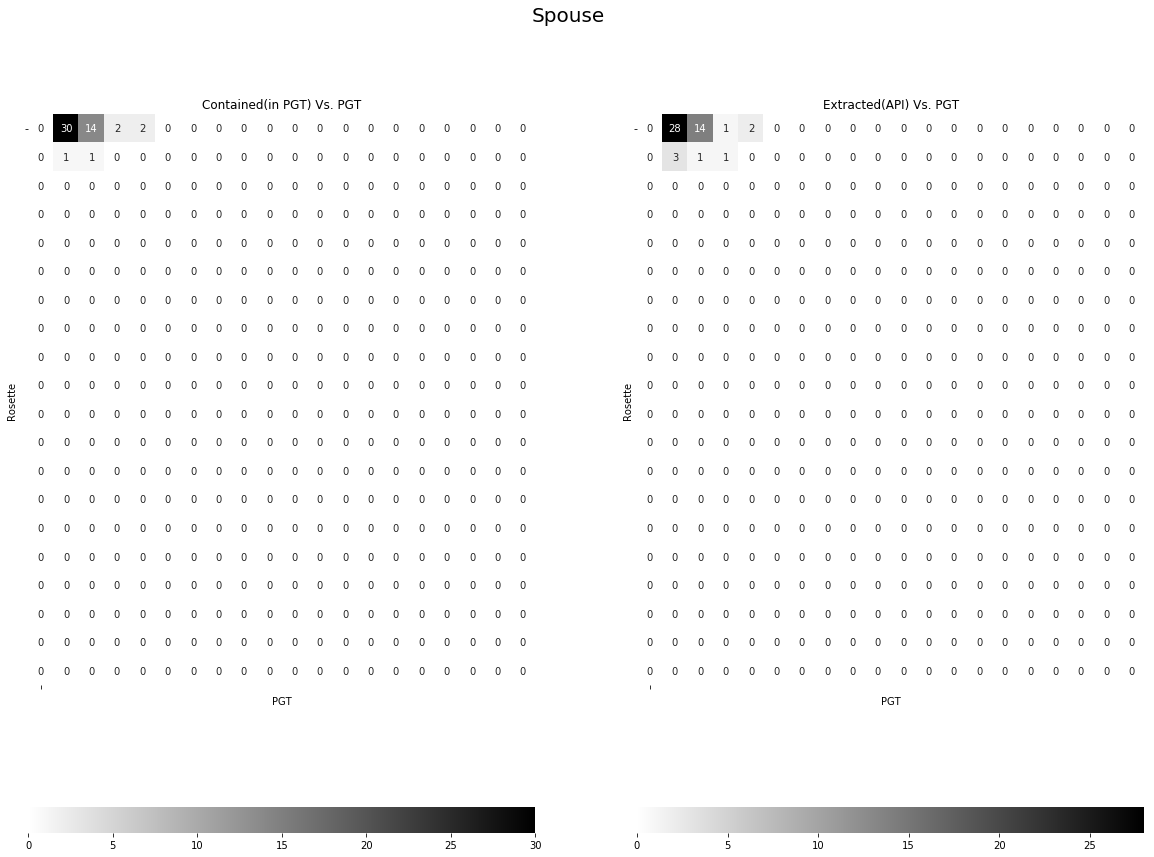

C:\Users\Bhavya\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: ResourceWarning:

unclosed file <_io.BufferedWriter name='data/numpy_matrices/Person Spouse-50-matrix_cont.dat'>

C:\Users\Bhavya\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: ResourceWarning:

unclosed file <_io.BufferedWriter name='data/numpy_matrices/Person Spouse-50-matrix_extr.dat'>



In [48]:
# relation = rel_dict_rel
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle(RELATION, fontsize=20)


# Contained
sns.heatmap(matrix_cont, ax=ax1, fmt='.0f', cmap='gist_gray_r', xticklabels = [""], yticklabels = [""], annot = True, cbar_kws={"orientation": "horizontal"})
ax1.set_ylabel('Rosette')    
ax1.set_xlabel('PGT')
ax1.set_title('Contained(in PGT) Vs. PGT')

# Extracted
sns.heatmap(matrix_extr, ax=ax2, fmt='.0f', cmap='gist_gray_r', xticklabels = [""], yticklabels = [""], annot = True, cbar_kws={"orientation": "horizontal"})
ax2.set_ylabel('Rosette')    
ax2.set_xlabel('PGT')
ax2.set_title('Extracted(API) Vs. PGT')

plt.show()
fig.savefig("data/img/{}-{}.png".format(relation,n))

# Saving Weight Matrices
matrix_cont.dump('data/numpy_matrices/{}-{}-matrix_cont.dat'.format(relation,n))
matrix_extr.dump('data/numpy_matrices/{}-{}-matrix_extr.dat'.format(relation,n))

### Number of Extractions vs. Page Length

In [50]:
## Defining the Relation
RELATION = 'Spouse'
NAME = DF[RELATION]
doc_len_rel = NAME['doc_len']
rel_dict_rel = NAME['rel_dict']

# Merging two dfs
doc_len_df = rel_dict_to_df(doc_len_rel)
rel_df = rel_dict_to_df(rel_dict_rel)
merged_df = rel_df.join(doc_len_df, how='left')
merged_df = merged_df.reset_index()[['Extracted', 'Doc_Length', 'PGT']].groupby(['Doc_Length']).mean()
extractions = merged_df['Extracted'].to_dict()
gt = merged_df['PGT'].to_dict()


#### SCATTER PLOT ####

trace1 = go.Scatter(
    x = list(extractions.keys()),
    y = list(extractions.values()),
    mode = 'markers',
    name = 'Extractions'
    )

trace2 = go.Scatter(
    x = list(gt.keys()),
    y = list(gt.values()),
    mode = 'markers',
    name = 'PGT',
    opacity = 0.8
    )

data = [trace1]
# data = [trace1, trace2]

layout = go.Layout(
    title=RELATION,
    showlegend=True,
    xaxis=dict(
        title='Page Length',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Extractions',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

### Missing Vs. Failure To Capture

In [13]:
## Defining the Relation
RELATION = 'Spouse'
NAME = DF[RELATION]
doc_len_rel = NAME['doc_len']
rel_dict_rel = NAME['rel_dict']
missing_rel = NAME['missing']

# Merging two dfs
doc_len_df = rel_dict_to_df(doc_len_rel)
rel_df = rel_dict_to_df(rel_dict_rel)
merged_df = rel_df.join(doc_len_df, how='left')
merged_df = merged_df[merged_df['Extracted'] < merged_df['PGT']]

In [14]:
relation = missing_rel 
topN_entities = merged_df['Name'].to_dict() 
ids = list(topN_entities.keys())
u = Utils()

### Creating threads for each Entity
threads = []
rel_dict = load_rel_dict(relation)
for i,n in topN_entities.items():
    threads.append( MissingExtractions(eid=i, name=n, relation=rel_dict_rel, rel_dict=rel_dict) )

### Waiting for each thread to complete
for t in threads:
    try:
        t.join()
    except Exception as e:
        pass


### Filling up the HeatMap
table = PrettyTable(['EID', 'Name', 'Missing'])
for i,t in enumerate(threads):
    try:
        eid, name, missing = t.get_values()
        rel_dict[eid] = {'Name':name, 'Missing':missing}
        table.add_row([eid, name, missing])
    except:
        print("Not saving in Dict", i, ids[i], u.id_to_name(ids[i]))

save_rel_dict(relation, rel_dict)
del u
print(table)

Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Saved
Save

C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: UserWarning:

No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Bhavya\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.




David Hare Page id " " does not match any pages. Try another id!
Not saving in Dict 40 Q1174676 David Hare
Done!
Saved
+----------+--------------------------------------------------+---------+
|   EID    |                       Name                       | Missing |
+----------+--------------------------------------------------+---------+
| Q101410  |                 François Fillon                  |    0    |
| Q102462  |                  James Stewart                   |    0    |
| Q102551  |                 Ernest Borgnine                  |    0    |
|  Q1035   |                  Charles Darwin                  |    1    |
| Q103894  |                  Alec Guinness                   |    1    |
|  Q10390  |                   John McCain                    |    1    |
| Q104027  |                   Kirk Douglas                   |    0    |
| Q104049  |                  Sidney Poitier                  |    0    |
| Q104791  |                    Ed Harris                     |    

In [37]:
missing_df = rel_dict_to_df(missing_rel)
rel_df = rel_dict_to_df(rel_dict_rel)
doc_len_df = rel_dict_to_df(doc_len_rel)

merged_df = rel_df.join(missing_df, how='inner')
merged_df = merged_df.drop('Name', axis=1)

##### Contained + Missing + FailureToCapture <====> Pseudo Ground Truth ##########
merged_df['FailureToCapture'] = merged_df['PGT'] - merged_df['Missing'] - merged_df['Contained']

merged_df = merged_df.join(doc_len_df, how='inner')
merged_df = merged_df.drop('Name', axis=1)

In [35]:
# Merging two dfs
merged_df = merged_df.reset_index()[['Doc_Length', 'PGT', 'Missing', 'FailureToCapture']].groupby(['Doc_Length']).mean()
failure = merged_df['FailureToCapture'].to_dict()
missing = merged_df['Missing'].to_dict()
gt = merged_df['PGT'].to_dict()


#### SCATTER PLOT ####

trace1 = go.Scatter(
    x = list(gt.keys()),
    y = list(gt.values()),
    mode = 'markers',
    name = 'PGT'
    )

trace2 = go.Scatter(
    x = list(missing.keys()),
    y = list(missing.values()),
    mode = 'markers',
    name = 'Missing',
    opacity = 0.8
    )

trace3 = go.Scatter(
    x = list(failure.keys()),
    y = list(failure.values()),
    mode = 'markers',
    name = 'Failure To Capture',
    opacity = 0.7
    )

# data = [trace1, trace2]
data = [trace1, trace2, trace3]

layout = go.Layout(
    title=RELATION,
    showlegend=True,
    xaxis=dict(
        title='Page Length',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Extractions',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [38]:
merged_df

,EntityName,Extracted,PGT,Contained,Missing,FailureToCapture,Doc_Length
Q101410,François Fillon,0,1,0,0,1,14980
Q102462,James Stewart,0,1,0,0,1,56861
Q102551,Ernest Borgnine,2,3,1,0,2,19858
Q1035,Charles Darwin,0,1,0,1,0,58381
Q103894,Alec Guinness,0,1,0,1,0,19443
Q10390,John McCain,0,2,0,1,1,92500
Q104027,Kirk Douglas,0,1,0,0,1,43513
Q104049,Sidney Poitier,0,1,0,0,1,12689
Q104791,Ed Harris,0,1,0,0,1,11429
Q104898,Norman Foster,0,1,0,1,0,11765


## END

### Extras

#### Other Graphs

In [ ]:
sns.distplot(list(dict_length.values()), hist=True, kde=False, 
             bins=12, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Document-Popularity Frequency-Distribution')
plt.xlabel('Popularity')
plt.ylabel('Count')

In [ ]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace

data = list(dict_length.values())

kde = gaussian_kde( data )
dist_space = linspace( min(data), max(data), 100 )
plt.plot( dist_space, kde(dist_space) )

In [ ]:
from scipy.interpolate import UnivariateSpline
N = len(dict_length)
n = N//10
s = list(dict_length.values())   # generate your data sample with N elements
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
plt.plot(x, f(x))
plt.show()

In [ ]:
import seaborn as sns

fig1 = sns.heatmap(matrix_cont, linewidth=0.5)
fig2 = sns.heatmap(matrix_extr, linewidth=0.5)

fig1.set_title('Contained(in PGT) Vs. PGT')
fig2.set_title('Extracted(API) Vs. PGT')
fig1.set(xlabel='PGT', ylabel='API')
fig2.set(xlabel='PGT', ylabel='API')

# fig1.get_figure().savefig("data/img/{}-{}-matrix_cont.png".format(relation,n))
# fig2.get_figure().savefig("data/img/{}-{}-matrix_extr.png".format(relation,n))

matrix_cont.dump('data/numpy_matrices/{}-{}-matrix_cont.dat'.format(relation,n))
matrix_extr.dump('data/numpy_matrices/{}-{}-matrix_extr.dat'.format(relation,n))

In [ ]:
fig1.set(xlabel='PGT', ylabel='API')
fig1.set_title('Contained(in PGT) Vs. PGT')
fig1.get_figure()

In [ ]:
fig2.set(xlabel='PGT', ylabel='API')
fig2.set_title('Extracted(API) Vs. PGT')
fig2.get_figure()